In [210]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, math

In [211]:
def plot_figs(imgs, titles=None, max_col=4):
    """
    Plots list of images in a grid. 
    -----
    args imgs: list of images.
    args titles: list of titles, defaults to None.
    args max_col: number of column in the grid, defaults to 4.
    -----
    return: None.
    """
    n = len(imgs)
    
    # Each plot can hold up to 8 images.
    rows_per_set = 8 // max_col 
    fig_per_set = rows_per_set * max_col
    sets = math.ceil(n / fig_per_set)
    
    for s in range(sets):
        # starting index of your set
        start = s * fig_per_set
        
        # compute the number of images and rows in the current set 
        subset_len = min(start+fig_per_set, n) - start
        nb_rows = math.ceil(subset_len / max_col)
        
        # set subplot map 
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if titles is not None: 
                plt.title(titles[start + i])
            else:
                plt.title(str(start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i], cmap='gray')
    plt.show()

In [212]:
def find_nearest_neighbor(sample, dataset, index=None):
    """
    Iterates through the dataset to return the nearest neighbor sample. 
    -----
    args sample: the reference sample. 
    args dataset: the dataset you are searching in, should be a list of items 
        with the same format as the sample.
    args index: if the sample is part of the dataset, set value to index of 
        sample within the dataset. Defaults to None. 
    -----
    return: index of the nn within the dataset, nn sample. 
    """
    l2_norms = []
    for i in range(len(dataset)):
        if i == index:
            l2_norms.append(float('inf'))
        else:
            l2_norms.append(np.linalg.norm(dataset[i] - sample, ord=2))
    min_index = np.argmin(l2_norms)
    return min_index, dataset[min_index]

In [213]:
def get_nn_same_class_metrics(X, Y):
    """
    Computes the number of samples in a dataset whose nearest neighbors is in the 
    same class. 
    -----
    args X: the dataset you are working with. 
    args Y: the corresponding classes of the dataset. 
    -----
    return: 
        - nb_same_class: (int) number of samples that are in the same class as its nn. 
        - fraction_same_class: (float) fraction of same class samples. 
    """
    NN_same_class = []
    for i in range(len(X)): 
        NN, _ = find_nearest_neighbor(X[i], X, i)
        if (Y[NN] == Y[i]): 
            NN_same_class.append(1) 
        else: 
            NN_same_class.append(0)
    nb_same_class = NN_same_class.count(1)
    frac_same_class = float(nb_same_class / len(X))
    
    return nb_same_class, frac_same_class

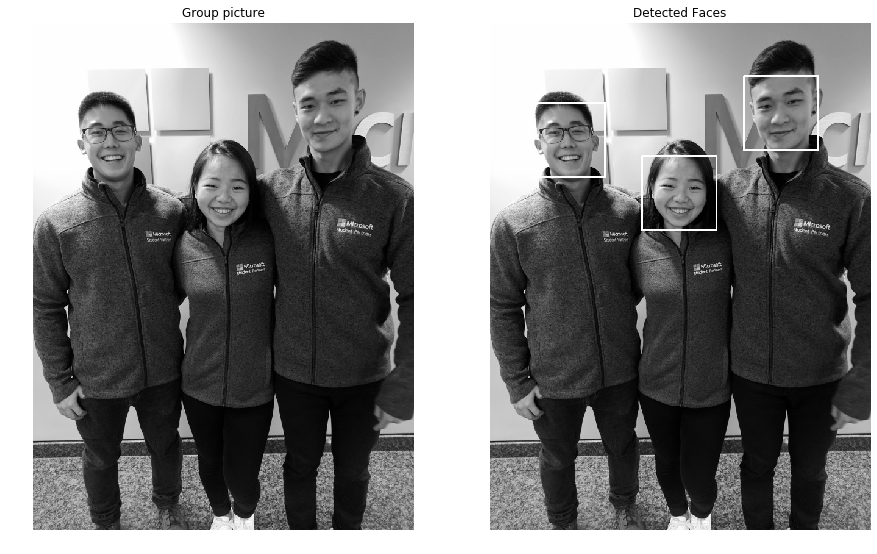

In [390]:
data_path = cv2.data.haarcascades
face_front = cv2.CascadeClassifier( os.path.join(data_path, 'haarcascade_frontalface_default.xml') )

# group = cv2.imread('./group.jpeg', cv2.IMREAD_GRAYSCALE)
faces = face_front.detectMultiScale(group, 1.5, 2)

detected_group = group.copy()
for (x, y, w, h) in faces: 
    cv2.rectangle(detected_group, (x,y), (x+w, y+h), (255,0,0), 2)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.title("Group picture")
plt.imshow(group, cmap='gray'), plt.axis('off')

plt.subplot(122), plt.title("Detected Faces")
plt.imshow(detected_group, cmap='gray'), plt.axis('off')
plt.show()  

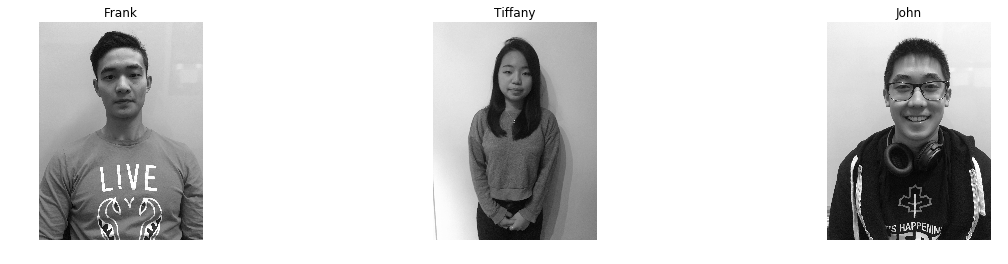

In [271]:
ds_path = './dataset/'

# Build dataset 
files = os.listdir(ds_path)
files = [file for file in files if file.endswith('.jpeg')]
files.sort()

imgs, Y = [], []

for file in files: 
    imgs.append(cv2.imread(ds_path + file, cv2.IMREAD_GRAYSCALE))
    Y.append(file.split('_')[0])

# Get class names 
cls = set(Y)

# Plot a sample from each class 
titles = []
sample_img = []
for c in cls: 
    idx = Y.index(c)
    titles.append(c)
    sample_img.append(imgs[idx])

plot_figs(sample_img, titles, max_col=3)

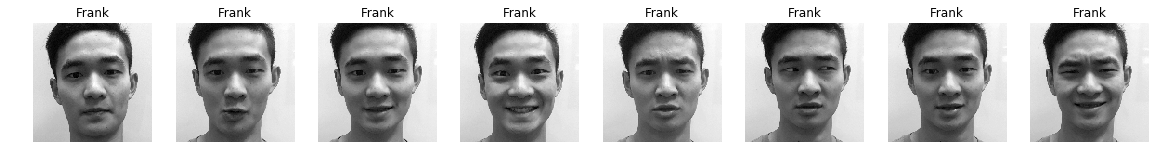

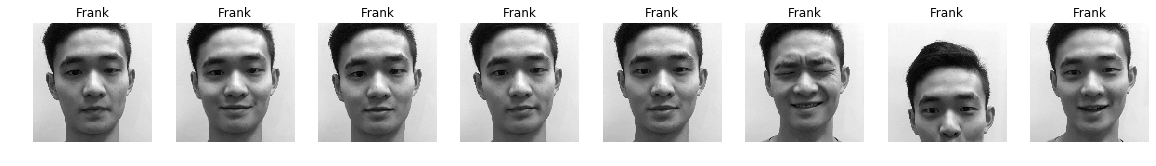

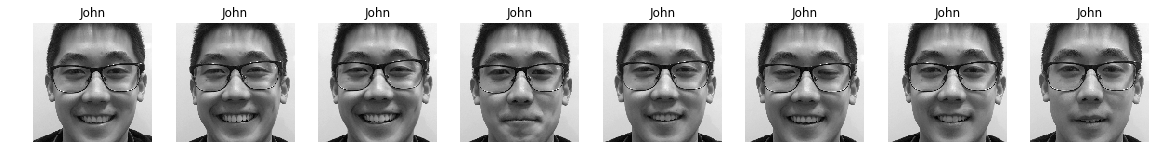

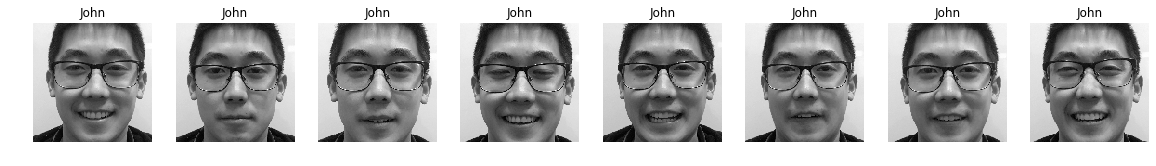

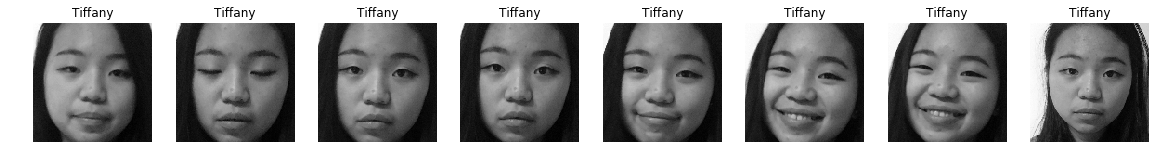

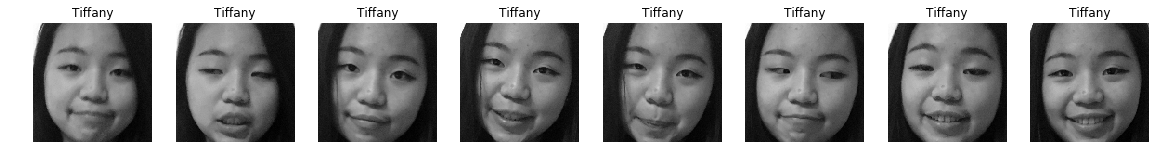

In [391]:
# Crop and resize images to only keep the faces
size = (128, 128)

X = []

for img in imgs: 
    faces = face_front.detectMultiScale(img, 1.8, 2)
    x, y, w, h = faces[0] # we know that there is only one face per training sample. 
    face_extract = img[y:y+h, x:x+w]
    face_extract = cv2.resize(face_extract, size) 
    X.append(face_extract)
    
plot_figs(X, Y, max_col=8)

#### Describe how you selected the images with respect to the conditions of the detection/classication methods

### PCA

In [392]:
# Split the data using train_test_split
split = 0.7
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, train_size=split )

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


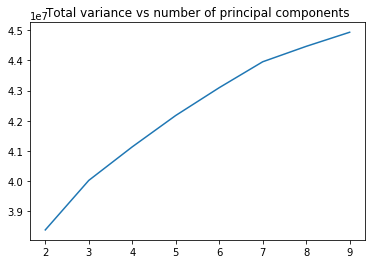

In [393]:
n_components = list(range(2, 10))
total_variance = []
for nb in n_components:
    pca = PCA(n_components=nb)
    pca.fit( X_train )
    variance = pca.explained_variance_
    total_variance.append(np.sum(variance))
    
plt.plot(n_components, total_variance)
plt.title('Total variance vs number of principal components')
plt.show()

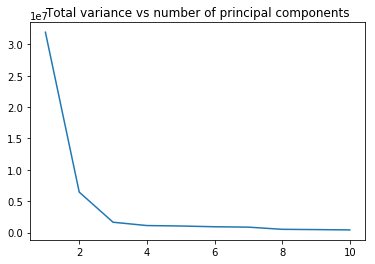

In [394]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit( X_train )
variance = pca.explained_variance_

plt.plot(list(range(1, n_components + 1)), variance)
plt.title('Total variance vs number of principal components')
plt.show()

In [405]:
# Choose n_components = 4 and reduce X_train and X_test to that dimensionality.
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform( X_train )
X_test_pca = pca.transform( X_test )
X_train_pca = np.array(X_train_pca)
X_test_pca = np.array(X_test_pca)

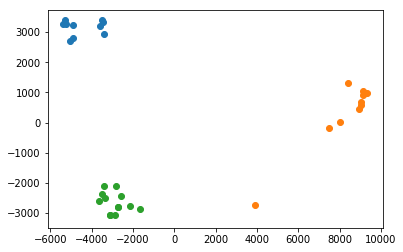

In [406]:
for c in cls: 
    x_cls = X_train_pca[ Y_train == c, :]
    plt.scatter(x_cls[:,0], x_cls[:,1])

plt.show()

In [407]:
nb_PCA, frac_PCA = get_nn_same_class_metrics(X_train_pca, Y_train)
nb_original, frac_original = get_nn_same_class_metrics(X_train, Y_train)

print("PCA: {} samples out of {} had the same class as its nearest neighbor, that is {}%."
          .format(nb_PCA, len(X_train_pca), frac_PCA * 100))
print("Original: {} samples out of {} had the same class as its nearest neighbor, that is {:.2f}%."
          .format(nb_original, len(X_train), frac_original * 100))

PCA: 33 samples out of 33 had the same class as its nearest neighbor, that is 100.0%.
Original: 26 samples out of 33 had the same class as its nearest neighbor, that is 78.79%.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_pca, y_train)
neigh.predict(X_train)

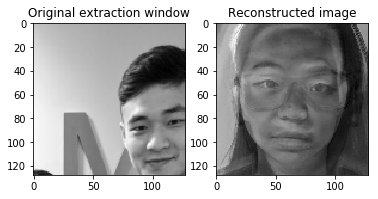

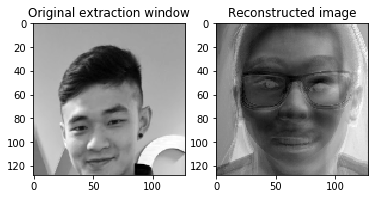

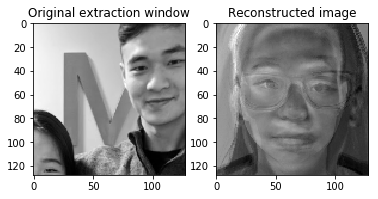

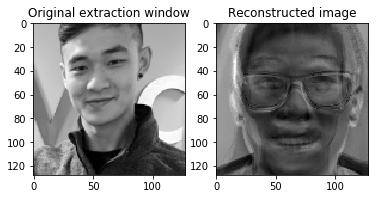

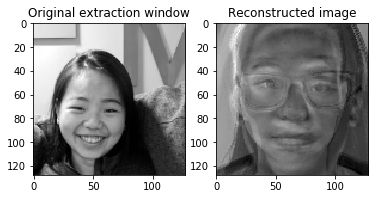

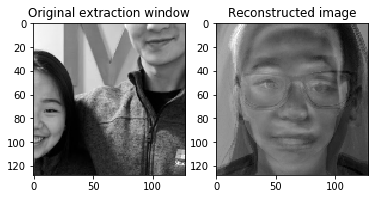

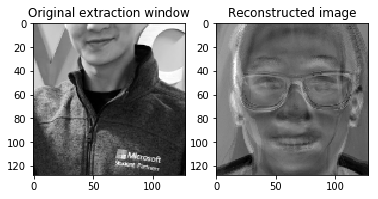

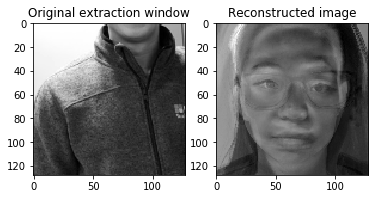

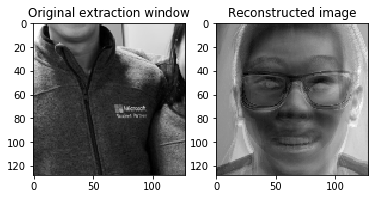

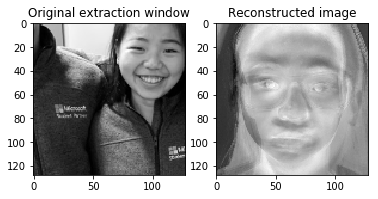

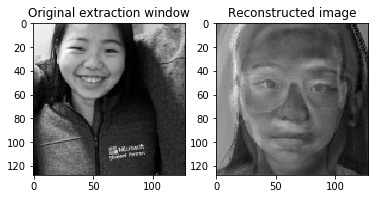

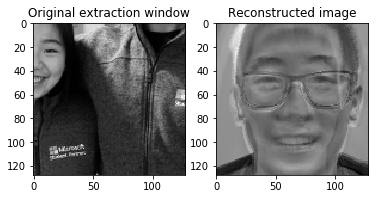

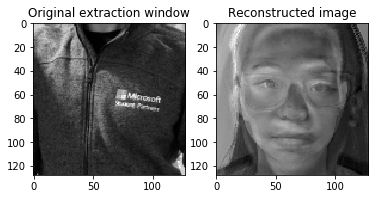

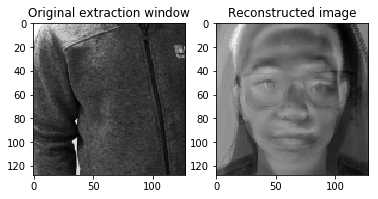

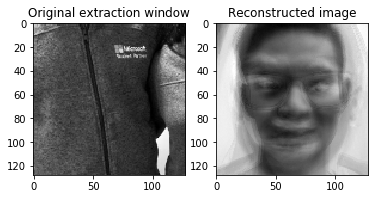

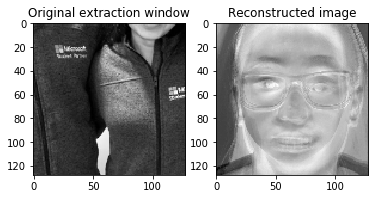

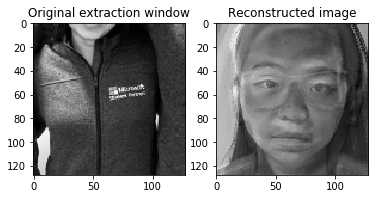

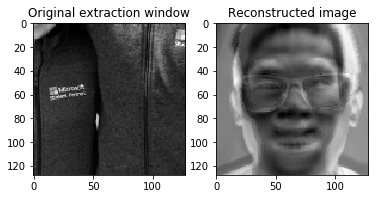

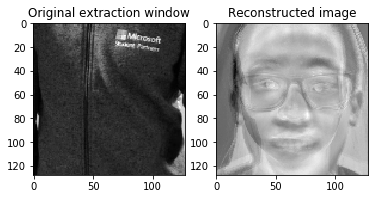

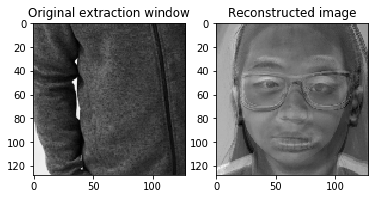

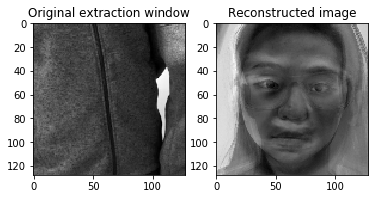

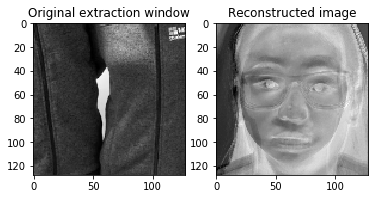

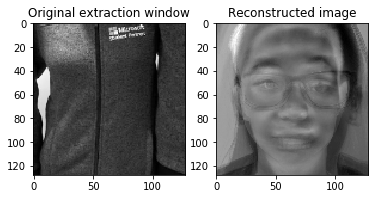

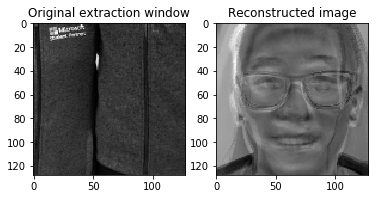

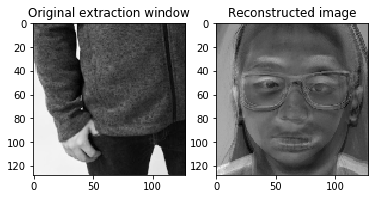

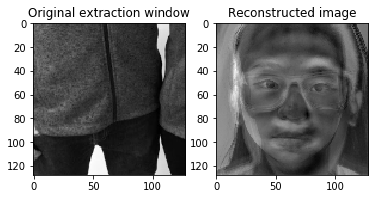

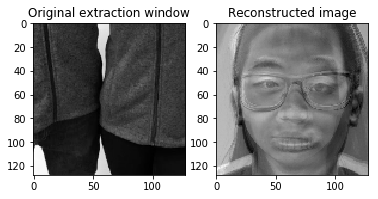

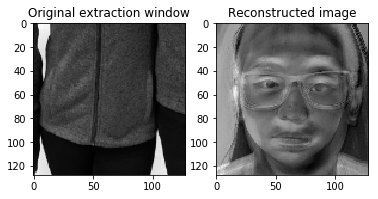

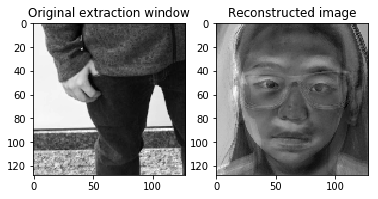

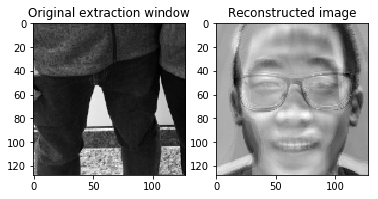

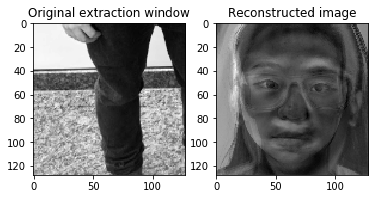

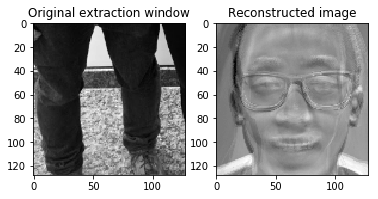

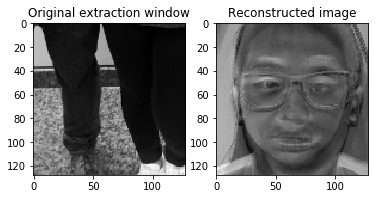

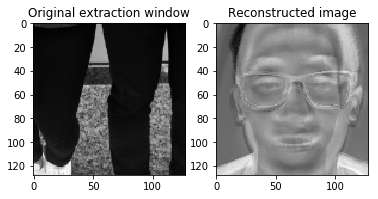

34


In [403]:
window_size_x, window_size_y = size
step_size = 50
h, w = group.shape 
thres = 100
pca_components = pca.components_
detected_faces = []

group = (group - np.mean(group)) / np.std(group)

for y in range(0, h - window_size_y, step_size):
    for x in range(0, w - window_size_x, step_size):
        extract = group[y:y+window_size_y,x:x+window_size_x]
        extract_c = extract.reshape(-1)
        mean_diff = extract_c - np.mean(extract_c)
        eigen_x = np.matmul(pca_components, mean_diff)
        result = np.zeros((128 * 128)).astype(np.float64)
        for i in range(len(eigen_x)): 
            eigen_x[i] * pca_components[i]
            result += eigen_x[i] * pca_components[i]
        result = result.reshape(size)
        if np.linalg.norm(result - extract, ord=2) < thres: 
            detected_faces.append([extract, result])
            plt.subplot(121), plt.title("Original extraction window")
            plt.imshow(extract, cmap='gray')
            plt.subplot(122), plt.title("Reconstructed image")
            plt.imshow(result, cmap='gray')
            plt.show()
print(len(detected_faces))
        

76.74553880365872


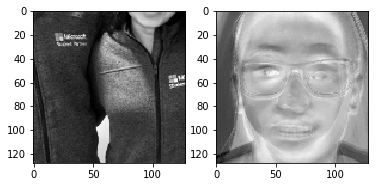

In [404]:
# thres = 
x, y = (200, 100)
# group = cv2.imread('./group.jpeg', cv2.IMREAD_GRAYSCALE)
group = (group - np.mean(group))/np.std(group)
extract = group[x:x+128, y:y+128]
plt.subplot(121)
plt.imshow(extract, cmap = 'gray')
extract = cv2.resize(extract, size) 
extract = extract.reshape(-1)
mean = extract - np.mean(extract)
eigen_x = np.matmul(pca_components, mean)
result = np.full((128 * 128), 0).astype(np.float64)
for i in range(len(eigen_x)): 
    eigen_x[i] * pca_components[i]
    result += eigen_x[i] * pca_components[i]
result = result.reshape(size)
extract = extract.reshape(size)
print(np.linalg.norm(result - extract, ord=2))
plt.subplot(122)
plt.imshow(result, cmap = 'gray')
plt.show()

In [143]:
pca_components = pca.components_
print(pca_components.shape)

(7, 16384)


In [144]:
(pca_components * eigen_x).shape

(7, 16384)

In [145]:
print(pca_components)

[[ 0.00098732  0.00096004  0.00098749 ...  0.01356572  0.0135736
   0.013556  ]
 [ 0.00291187  0.00291931  0.00295952 ... -0.00319956 -0.00312735
  -0.00305461]
 [ 0.00339796  0.00349018  0.0032983  ... -0.01315321 -0.01361334
  -0.01412275]
 ...
 [-0.00197614 -0.00193722 -0.00186953 ...  0.00249849  0.00325808
   0.0043162 ]
 [ 0.00125832  0.00135459  0.00112951 ...  0.00109069  0.00098908
   0.00122143]
 [ 0.00051857 -0.00012072  0.00026212 ... -0.00204604 -0.00092496
  -0.00038652]]


In [152]:
print(eigen_x * pca_components)

ValueError: operands could not be broadcast together with shapes (7,) (7,16384) 

In [162]:
eigen_x = np.matmul(pca_components, extract)
print(len(eigen_x))

7


In [291]:
mean = extract - np.mean(extract)
eigen_x = np.matmul(pca_components, mean)
result = np.full((128 * 128), np.mean(extract)).astype(np.float64)
subplot = 180
plt.figure(figsize=(20, 20))
for i in range(len(eigen_x)): 
    plt.subplot(subplot + i + 1), plt.imshow((eigen_x[i] * pca_components[i]).reshape(size), cmap='gray')
    result += eigen_x[i] * pca_components[i]
print(np.linalg.norm(result - extract, ord=2))

ValueError: shapes (4,16384) and (128,128) not aligned: 16384 (dim 1) != 128 (dim 0)

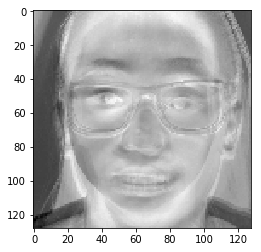

In [409]:
plt.imshow(result.reshape(size), cmap='gray')

11787.838198291738


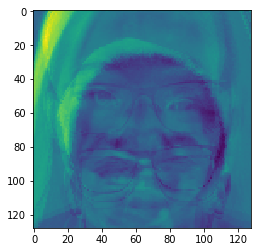

In [205]:
eigen_x = np.matmul(pca_components, extract)
eigen_x = np.matmul(eigen_x, pca_components)
plt.imshow(eigen_x.reshape(size))
print(np.linalg.norm(eigen_x - extract))

(833, 625)


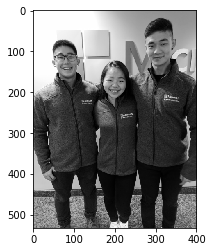

In [402]:
group = cv2.resize(group, (int(group.shape[1] * 128 / 200), int(group.shape[0] * 128 / 200)))
print(re.shape)
plt.imshow(group, cmap='gray')